### Imports

In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [2]:
# import data
df = pd.read_csv('/Users/gabrielwarner/Downloads/pgaTourData.csv')
df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"


### Data Cleaning

In [3]:
# Replace NaN with 0 in Top 10 
df['Top 10'].fillna(0, inplace=True)
df['Top 10'] = df['Top 10'].astype(int)

# Replace NaN with 0 in # of wins
df['Wins'].fillna(0, inplace=True)
df['Wins'] = df['Wins'].astype(int)

# Drop NaN values 
df.dropna(axis = 0, inplace=True)
# Change Rounds to int
df['Rounds'] = df['Rounds'].astype(int)

# Change Points to int 
df['Points'] = df['Points'].apply(lambda x: x.replace(',',''))
df['Points'] = df['Points'].astype(int)

# Remove the $ and commas in money 
df['Money'] = df['Money'].apply(lambda x: x.replace('$',''))
df['Money'] = df['Money'].apply(lambda x: x.replace(',',''))
df['Money'] = df['Money'].astype(float)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1677
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Player Name         1674 non-null   object 
 1   Rounds              1674 non-null   int64  
 2   Fairway Percentage  1674 non-null   float64
 3   Year                1674 non-null   int64  
 4   Avg Distance        1674 non-null   float64
 5   gir                 1674 non-null   float64
 6   Average Putts       1674 non-null   float64
 7   Average Scrambling  1674 non-null   float64
 8   Average Score       1674 non-null   float64
 9   Points              1674 non-null   int64  
 10  Wins                1674 non-null   int64  
 11  Top 10              1674 non-null   int64  
 12  Average SG Putts    1674 non-null   float64
 13  Average SG Total    1674 non-null   float64
 14  SG:OTT              1674 non-null   float64
 15  SG:APR              1674 non-null   float64
 16  SG:ARG

### Data Exploration

/Users/gabrielwarner/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gabrielwarner/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/gabrielwarner/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

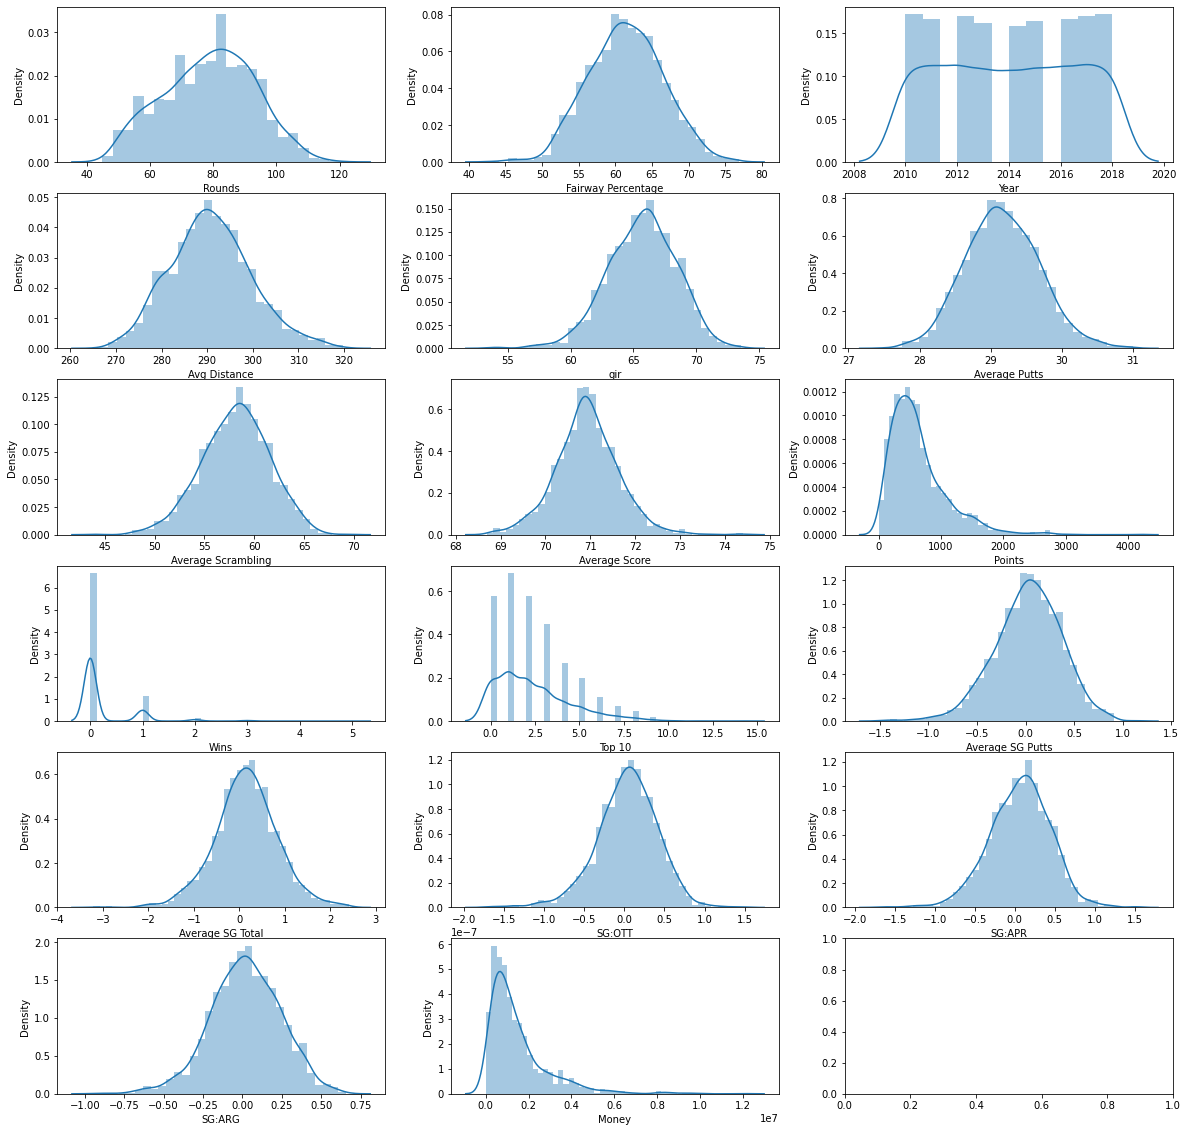

In [5]:
#Exploratory Data Analysis / looking at distrubition
f, ax = plt.subplots(nrows = 6, ncols = 3, figsize=(20,20))
distribution = df.loc[:,df.columns!='Player Name'].columns
rows = 0
cols = 0
for i, column in enumerate(distribution):
    p = sns.distplot(df[column], ax=ax[rows][cols])
    cols += 1
    if cols == 3:
        cols = 0
        rows += 1

In [6]:
#Number of wins per player
win = df.groupby('Year')['Wins'].value_counts()
win = win.unstack()
win.fillna(0, inplace=True)

# Converting win into ints
win = win.astype(int)

print(win)

Wins    0   1  2  3  4  5
Year                     
2010  166  21  5  0  0  0
2011  156  25  5  0  0  0
2012  159  26  4  1  0  0
2013  152  24  3  0  0  1
2014  142  29  3  2  0  0
2015  150  29  2  1  1  0
2016  152  28  4  1  0  0
2017  156  30  0  3  1  0
2018  158  26  5  3  0  0


In [7]:
# Who made the most money
money_ranking = df[['Year','Player Name','Money']].copy()
money_ranking.sort_values(by='Money', inplace=True, ascending=False)
print(money_ranking.head())


     Year     Player Name       Money
647  2015   Jordan Spieth  12030465.0
361  2017   Justin Thomas   9921560.0
303  2017   Jordan Spieth   9433033.0
729  2015       Jason Day   9403330.0
520  2016  Dustin Johnson   9365185.0


In [8]:
#Who made the most each year
money_rank = money_ranking.groupby('Year')['Money'].max()
money_rank = pd.DataFrame(money_rank)
print(money_rank.iloc[0,0])

indexs = np.arange(2010, 2018)
names = []
for i in range(money_rank.shape[0]):
    temp = df.loc[df['Money'] == money_rank.iloc[i,0],'Player Name']
    names.append(str(temp.values[0]))

money_rank['Player Name'] = names
print(money_rank)

4910477.0
           Money     Player Name
Year                            
2010   4910477.0     Matt Kuchar
2011   6683214.0     Luke Donald
2012   8047952.0    Rory McIlroy
2013   8553439.0     Tiger Woods
2014   8280096.0    Rory McIlroy
2015  12030465.0   Jordan Spieth
2016   9365185.0  Dustin Johnson
2017   9921560.0   Justin Thomas
2018   8694821.0   Justin Thomas


In [9]:
#Creating a new column that has a 1 if greater than 50000
df['Money'] = pd.to_numeric(df.Money, errors='coerce')
df['new_money'] = df['Money'] > 500000
df["new_money"] = df["new_money"].astype(int)

<AxesSubplot:>

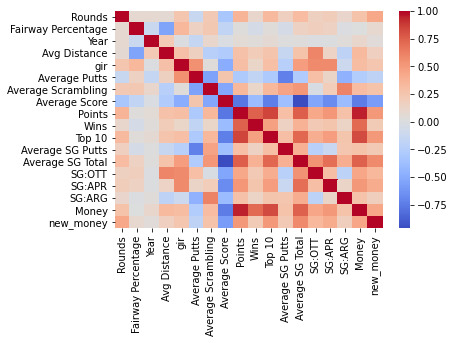

In [10]:
#creating a heatmap to see corr
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm')

In [11]:
#looking at the corr
df.corr()['Money']

Rounds                0.278091
Fairway Percentage    0.016237
Year                  0.108244
Avg Distance          0.329295
gir                   0.313770
Average Putts        -0.257832
Average Scrambling    0.317777
Average Score        -0.746499
Points                0.949286
Wins                  0.721665
Top 10                0.827215
Average SG Putts      0.278895
Average SG Total      0.747042
SG:OTT                0.441912
SG:APR                0.510740
SG:ARG                0.278901
Money                 1.000000
new_money             0.445615
Name: Money, dtype: float64

In [12]:
# Percentage of people who did not place in the top 10 each year
top10 = df.groupby('Year')['Top 10'].value_counts()
top10 = top10.unstack()
top10.fillna(0, inplace=True)
players = top10.apply(lambda x: np.sum(x), axis=1)

no_top10 = top10[0]/players * 100
print(no_top10)

Year
2010    17.187500
2011    25.268817
2012    23.157895
2013    18.888889
2014    16.477273
2015    18.579235
2016    20.000000
2017    15.789474
2018    17.187500
dtype: float64


In [13]:
# Defining the players that had a win or more in each year 
champion = df.loc[df['Wins'] >= 1, :]
champion =champion.sort_values(by="Wins", ascending=False)
champion.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money,new_money
997,Tiger Woods,61,62.50,2013,293.2,67.59,28.85,60.00,68.944,3059,5,7,0.426,2.064,-0.142,1.533,0.247,8553439.0,1
647,Jordan Spieth,91,62.91,2015,291.8,67.87,27.82,65.03,68.938,4169,4,14,0.571,2.154,0.494,0.618,0.471,12030465.0,1
361,Justin Thomas,86,54.09,2017,309.3,67.33,28.29,60.54,69.359,2689,4,9,0.332,1.724,0.452,0.738,0.289,9921560.0,1
141,Bubba Watson,90,58.27,2018,313.1,68.21,29.33,56.64,70.384,1879,3,5,0.001,0.555,0.780,0.005,-0.231,5793748.0,1
137,Justin Thomas,91,58.41,2018,311.8,68.77,28.33,62.47,69.118,2634,3,8,0.272,1.835,0.408,0.844,0.311,8694821.0,1


In [14]:
#new column that shows me who earned points
df['new_points'] = df['Points'] > 0
df['new_points'] = df['new_points'].astype(int)
df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money,new_money,new_points
0,Henrik Stenson,60,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,0,5,-0.207,1.153,0.427,0.960,-0.027,2680487.0,1,1
1,Ryan Armour,109,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006,1,3,-0.058,0.337,-0.012,0.213,0.194,2485203.0,1,1
2,Chez Reavie,93,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020,0,3,0.192,0.674,0.183,0.437,-0.137,2700018.0,1,1
3,Ryan Moore,78,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,0,5,-0.271,0.941,0.406,0.532,0.273,1986608.0,1,1
4,Brian Stuard,103,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,0,3,0.164,0.062,-0.227,0.099,0.026,1089763.0,1,1


In [15]:
#If they have any wins they are 1 and no wins is zero
df['new_wins'] = df['Wins'] > 0
df['new_wins'] = df['new_wins'].astype(int)
df.head()


,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,...,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money,new_money,new_points,new_wins
0,Henrik Stenson,60,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,...,5,-0.207,1.153,0.427,0.960,-0.027,2680487.0,1,1,0
1,Ryan Armour,109,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006,...,3,-0.058,0.337,-0.012,0.213,0.194,2485203.0,1,1,1
2,Chez Reavie,93,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020,...,3,0.192,0.674,0.183,0.437,-0.137,2700018.0,1,1,0
3,Ryan Moore,78,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,...,5,-0.271,0.941,0.406,0.532,0.273,1986608.0,1,1,0
4,Brian Stuard,103,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,...,3,0.164,0.062,-0.227,0.099,0.026,1089763.0,1,1,0


In [16]:
#creating binned_points which split players up by points
df['binned_points'] = pd.qcut(df['Points'], q=3)
df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,...,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money,new_money,new_points,new_wins,binned_points
0,Henrik Stenson,60,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,...,-0.207,1.153,0.427,0.960,-0.027,2680487.0,1,1,0,"(682.333, 4169.0]"
1,Ryan Armour,109,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006,...,-0.058,0.337,-0.012,0.213,0.194,2485203.0,1,1,1,"(682.333, 4169.0]"
2,Chez Reavie,93,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020,...,0.192,0.674,0.183,0.437,-0.137,2700018.0,1,1,0,"(682.333, 4169.0]"
3,Ryan Moore,78,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,...,-0.271,0.941,0.406,0.532,0.273,1986608.0,1,1,0,"(682.333, 4169.0]"
4,Brian Stuard,103,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,...,0.164,0.062,-0.227,0.099,0.026,1089763.0,1,1,0,"(389.333, 682.333]"


In [17]:
#viewing the number of players in each bin
df['binned_points'].value_counts()

(682.333, 4169.0]     558
(389.333, 682.333]    558
(2.999, 389.333]      558
Name: binned_points, dtype: int64

In [18]:
#making it a string 
df['binned_points'] = df['binned_points'].astype('string')

In [19]:
df = df.replace(['(389.333, 682.333]', '(2.999, 389.333]', '(682.333, 4169.0]'], ['0', '1', '2'])

### Model Preperation

In [20]:
#creaing my x and y for train test split
y = df['binned_points']

X = df.drop(['new_money',"Money", "Player Name","Wins",'Top 10',"Year",
            'new_points','new_wins', 'binned_points','Points'], axis=1)

In [21]:
# Initial Train-Test Split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.30, random_state=2021)


In [22]:
#2nd tran test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.30, random_state=2021)

In [23]:
#Preprocessing checking for missing data
X_train.isna().sum()

Rounds                0
Fairway Percentage    0
Avg Distance          0
gir                   0
Average Putts         0
Average Scrambling    0
Average Score         0
Average SG Putts      0
Average SG Total      0
SG:OTT                0
SG:APR                0
SG:ARG                0
dtype: int64

In [24]:
#Checking for missing data
X_val.isna().sum()

Rounds                0
Fairway Percentage    0
Avg Distance          0
gir                   0
Average Putts         0
Average Scrambling    0
Average Score         0
Average SG Putts      0
Average SG Total      0
SG:OTT                0
SG:APR                0
SG:ARG                0
dtype: int64

In [25]:
#Scaling my data
num_cols = list(X.select_dtypes('number').columns)
num_cols

['Rounds',
 'Fairway Percentage',
 'Avg Distance',
 'gir',
 'Average Putts',
 'Average Scrambling',
 'Average Score',
 'Average SG Putts',
 'Average SG Total',
 'SG:OTT',
 'SG:APR',
 'SG:ARG']

In [26]:
# Instantiate StandardScaler
scaler = StandardScaler()

In [27]:
# fit on Imputed training data
scaler.fit(X_train[num_cols])

StandardScaler()

In [28]:
# transform training and validation data
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)

In [29]:
#modeling function
# Instantiate Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
def modeling_function(model, X_train, y_train, X_val, y_val):

    # fit model on training data
    model.fit(X_train, y_train)

    # make predictions on training and validation data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Print accuracy score
    print('Training accuracy: ', accuracy_score(y_train, train_preds))
    print('Validation accuracy: ', accuracy_score(y_val, val_preds))

    # return fitted model
    return model

### Logistic Regression

In [30]:
# initiate model and run through modeling function
logreg = LogisticRegression(solver='liblinear')
logreg = modeling_function(logreg, X_train, y_train, X_val, y_val)

Training accuracy:  0.7155067155067155
Validation accuracy:  0.6732954545454546


### Logistic Regression (positive money and negative score data frame)

In [31]:
player_progression = pd.DataFrame()
for player in df['Player Name'].unique():
    frame = df[df['Player Name'] == player]
    #frame = frame.sort_values("Year")
    year = frame.Year
    frame = frame.select_dtypes('number').diff()
    frame.Year = year
    frame['player_name'] = player
    player_progression = player_progression.append(frame)
player_progression = player_progression.dropna()
df1 = player_progression.groupby(by=["player_name"]).mean()
df1['positive_money'] = df1['Money'] > 0
df1['positive_money'] = df1['positive_money'].astype(int)
df1['negative_score'] = df1['Average Score'] < 0
df1['negative_score'] = df1['negative_score'].astype(int)
df2 = df1[(df1.positive_money == 1) & (df1.negative_score ==1)]
df2 = df2.sort_values(by=['Money'], ascending = False)

In [32]:
#creaing my x and y for train test split
y_2 = df['binned_points']

X_2 = df.drop(['new_money',"Money", "Player Name","Wins",'Top 10',"Year",
            'new_points','new_wins', 'binned_points','Points'], axis=1)

In [33]:
# Initial Train-Test Split
X_tr_2, X_test_2, y_tr_2, y_test_2 = train_test_split(X_2, y_2, test_size=.30, random_state=2021)

In [34]:
#2nd tran test split
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_tr_2, y_tr_2, test_size=.30, random_state=2021)

In [35]:
#Scaling my data
num_cols_2 = list(X_2.select_dtypes('number').columns)
num_cols_2

['Rounds',
 'Fairway Percentage',
 'Avg Distance',
 'gir',
 'Average Putts',
 'Average Scrambling',
 'Average Score',
 'Average SG Putts',
 'Average SG Total',
 'SG:OTT',
 'SG:APR',
 'SG:ARG']

In [36]:
# Instantiate StandardScaler
scaler = StandardScaler()

In [37]:
# fit on Imputed training data
scaler.fit(X_train_2[num_cols_2])

StandardScaler()

In [38]:
# transform training and validation data
X_train_scaled_2 = pd.DataFrame(scaler.transform(X_train_2[num_cols_2]), columns=num_cols)
X_val_scaled_2 = pd.DataFrame(scaler.transform(X_val_2[num_cols_2]), columns=num_cols)

In [39]:
# initiate model and run through modeling function
logreg_2 = LogisticRegression(solver='liblinear')
logreg_2 = modeling_function(logreg_2, X_train_2, y_train_2, X_val_2, y_val_2)

Training accuracy:  0.7155067155067155
Validation accuracy:  0.6732954545454546




### Random Forest Model

In [40]:
rf = RandomForestClassifier(random_state=2021)
rf = modeling_function(rf, X_train, y_train, X_val, y_val)

Training accuracy:  1.0
Validation accuracy:  0.6619318181818182


In [41]:
# Create Param Grid 
param_grid = {'n_estimators': [50, 75, 100],
                'max_depth': [5, 10, 15, 20, 25],
                'min_samples_leaf': [5, 7, 10, 12],
             'n_jobs': [-1],
             'criterion': ['gini', 'entropy']}


In [42]:
# Create GridSearchCV
rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy')


In [43]:
#fitting training data
rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=2021),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [5, 7, 10, 12],
                         'n_estimators': [50, 75, 100], 'n_jobs': [-1]},
             scoring='accuracy')

In [44]:
#finding my best params
best_model = rf_gs.best_estimator_

In [45]:
rf_gs.best_params_


{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 7,
 'n_estimators': 100,
 'n_jobs': -1}

In [46]:
#calling modeling function
modeling_function(best_model, X_train, y_train, X_val, y_val)

Training accuracy:  0.8363858363858364
Validation accuracy:  0.6534090909090909


RandomForestClassifier(max_depth=15, min_samples_leaf=7, n_jobs=-1,
                       random_state=2021)

In [47]:
# Create Param Grid 
param_grid2 = {'n_estimators': [90, 100, 110],
                'max_depth': [13, 14, 15, 16, 17],
                'min_samples_leaf': [7, 8, 9, 10],
             'n_jobs': [-1],
             'criterion': ['gini']}

In [48]:
# Create GridSearchCV
rf2_gs = GridSearchCV(estimator=rf, param_grid=param_grid2, scoring='accuracy')


In [49]:
rf2_gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=2021),
             param_grid={'criterion': ['gini'],
                         'max_depth': [13, 14, 15, 16, 17],
                         'min_samples_leaf': [7, 8, 9, 10],
                         'n_estimators': [90, 100, 110], 'n_jobs': [-1]},
             scoring='accuracy')

In [50]:

bestest_model = rf2_gs.best_estimator_

In [51]:
rf2_gs.best_params_

{'criterion': 'gini',
 'max_depth': 13,
 'min_samples_leaf': 8,
 'n_estimators': 90,
 'n_jobs': -1}

In [52]:
#calling modeling function
modeling_function(bestest_model, X_train, y_train, X_val, y_val)

Training accuracy:  0.8205128205128205
Validation accuracy:  0.6732954545454546


RandomForestClassifier(max_depth=13, min_samples_leaf=8, n_estimators=90,
                       n_jobs=-1, random_state=2021)

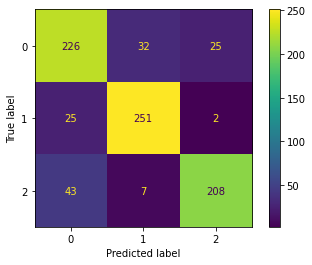

In [53]:
#plotting confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, X_train, y_train)

In [54]:
test_preds = rf_gs.predict(X_test)

In [55]:
accuracy_score(y_test, test_preds)

0.7216699801192843

Text(0, 0.5, 'Points Awarded')

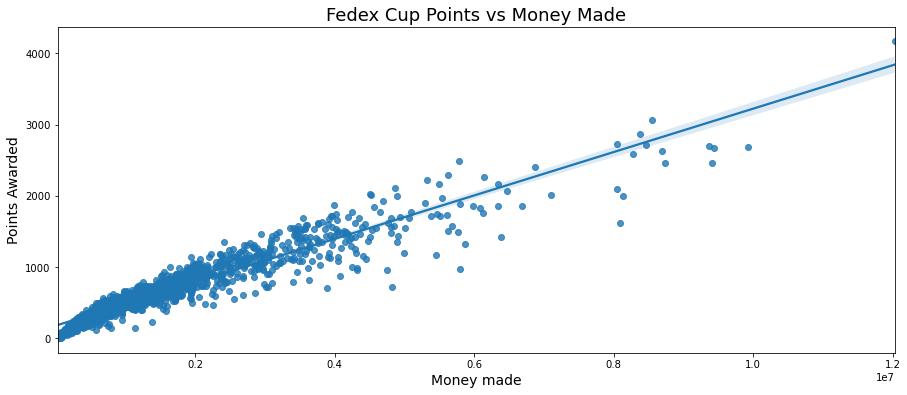

In [56]:
## Creates scatter plot of Fedex Points vs Tournament earnings
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Fedex Cup Points vs Money Made", fontsize=18)
sns.regplot(data=df, x='Money', y='Points')
ax.set_xlabel("Money made", fontsize=14)
ax.set_ylabel("Points Awarded", fontsize=14)

In [57]:
player_progression = pd.DataFrame()

for player in df['Player Name'].unique():
    frame = df[df['Player Name'] == player]
    frame = frame.sort_values("Year")
    year = frame.Year
    frame = frame.select_dtypes('number').diff()
    frame.Year = year
    frame['player_name'] = player
    player_progression = player_progression.append(frame)

In [58]:
player_progression = player_progression.dropna()

In [59]:
df1 = player_progression.groupby('player_name')['Points'].mean().sort_values(ascending=False)
df1

player_name
Martin Kaymer       1051.0
Andrew Landry        899.0
Andrew Putnam        834.0
Patrick Cantlay      810.0
Ryan Armour          784.0
                     ...  
Steve Elkington     -464.0
Tiger Woods         -553.5
Mackenzie Hughes    -747.0
Wesley Bryan        -827.0
Smylie Kaufman      -865.0
Name: Points, Length: 316, dtype: float64

In [60]:
player_progression['positive'] = player_progression['Points'] > 0

In [61]:
player_progression['improvement'] = player_progression['positive'].apply(lambda x: 1 if x else 0)

In [62]:
# Target
y1 = player_progression['improvement']
# Features
X1 = player_progression.drop(['new_money',"Money","Wins",'Top 10',"Year",
                              'Points','player_name', 'new_points',
                              'new_wins','improvement','positive'], axis=1)

In [63]:
# Initial Train-Test Split
X_tr1, X_test1, y_tr1, y_test1 = train_test_split(X1, y1, test_size=.15, random_state=2021)

In [64]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_tr1, y_tr1, test_size=.15, random_state=2021)

In [65]:
# Instantiate a SimpleImputer
imputer = SimpleImputer(strategy='mean')

In [66]:
# Fit on training data
imputer.fit(X_train1)

SimpleImputer()

In [67]:
# Transform training and validation data
X_train_imputed1 = pd.DataFrame(imputer.transform(X_train1), columns=X1.columns)
X_val_imputed1 = pd.DataFrame(imputer.transform(X_val1), columns=X1.columns)

In [68]:
print("X_train1 missing: ", X_train_imputed1.isna().sum().sum())
print('X_val1 missing: ', X_val_imputed1.isna().sum().sum())

X_train1 missing:  0
X_val1 missing:  0


In [69]:
num_cols = list(X1.select_dtypes('number').columns)
num_cols

['Rounds',
 'Fairway Percentage',
 'Avg Distance',
 'gir',
 'Average Putts',
 'Average Scrambling',
 'Average Score',
 'Average SG Putts',
 'Average SG Total',
 'SG:OTT',
 'SG:APR',
 'SG:ARG']

In [70]:
# initiate random forest model
rf = RandomForestClassifier(random_state=2021)

In [71]:
# run through modeling function
rf = modeling_function(rf, X_train1, y_train1, X_val1, y_val1)

Training accuracy:  1.0
Validation accuracy:  0.7848101265822784


In [72]:
# Create Param Grid 
param_grid1 = {'n_estimators': [55, 60, 65],
                'max_depth': [9, 10, 11, 12, 13],
                'min_samples_leaf': [7, 8, 9],
                'n_jobs': [-1],
                'criterion': ['gini']}

In [73]:
# Create GridSearchCV
rf_gs1 = GridSearchCV(estimator=rf, param_grid=param_grid1, scoring='accuracy')

In [74]:
rf_gs1.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=2021),
             param_grid={'criterion': ['gini'],
                         'max_depth': [9, 10, 11, 12, 13],
                         'min_samples_leaf': [7, 8, 9],
                         'n_estimators': [55, 60, 65], 'n_jobs': [-1]},
             scoring='accuracy')

In [75]:
best_model1 = rf_gs1.best_estimator_

In [76]:
rf_gs1.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 8,
 'n_estimators': 60,
 'n_jobs': -1}

In [77]:
rf1 = modeling_function(rf_gs1, X_train1, y_train1, X_val1, y_val1)

Training accuracy:  0.8766816143497758
Validation accuracy:  0.7974683544303798


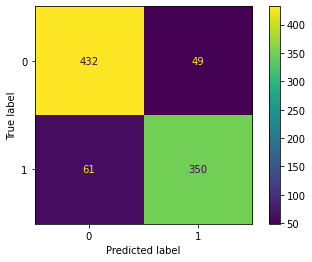

In [78]:
plot_confusion_matrix(rf1, X_train1, y_train1)

<AxesSubplot:xlabel='improvement', ylabel='Points'>

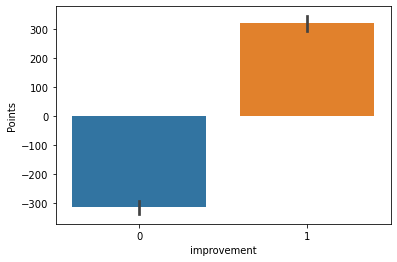

In [79]:
sns.barplot(x="improvement", y="Points", data=player_progression)

### Model Test Random Forest 

In [80]:
X_test_imputed1 = pd.DataFrame(imputer.transform(X_test1), columns=X1.columns)

In [81]:
X_test_scaled1 = pd.DataFrame(scaler.transform(X_test_imputed1[num_cols]), columns=num_cols)

In [82]:
test_preds = rf1.predict(X_test_scaled1)

In [83]:
accuracy_score(y_test1, test_preds )

0.7204301075268817

In [84]:
player_progression = pd.DataFrame()
for player in df['Player Name'].unique():
    frame = df[df['Player Name'] == player]
    #frame = frame.sort_values("Year")
    year = frame.Year
    frame = frame.select_dtypes('number').diff()
    frame.Year = year
    frame['player_name'] = player
    player_progression = player_progression.append(frame)
player_progression = player_progression.dropna()
df1 = player_progression.groupby(by=["player_name"]).mean()
df1['positive_money'] = df1['Money'] > 0
df1['positive_money'] = df1['positive_money'].astype(int)
df1['negative_score'] = df1['Average Score'] < 0
df1['negative_score'] = df1['negative_score'].astype(int)
df2 = df1[(df1.positive_money == 1) & (df1.negative_score ==1)]
df2 = df2.sort_values(by=['Money'], ascending = False)

### Predicting how much money a player should make

In [85]:
# import data
df = pd.read_csv('/Users/gabrielwarner/Downloads/pgaTourData.csv')
df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"


In [86]:
# Replace NaN with 0 in Top 10 
df['Top 10'].fillna(0, inplace=True)
df['Top 10'] = df['Top 10'].astype(int)

# Replace NaN with 0 in # of wins
df['Wins'].fillna(0, inplace=True)
df['Wins'] = df['Wins'].astype(int)

#Replace any ? with Nan
data = df.replace("?", "np.Nan")

# Drop NaN values 
df.dropna(axis = 0, inplace=True)


In [87]:
# Remove the $ and commas in money 
df['Money'] = df['Money'].apply(lambda x: x.replace('$',''))
df['Money'] = df['Money'].apply(lambda x: x.replace(',',''))
df['Money'] = df['Money'].astype(float)

In [88]:
# Change Money from float64 to numeric
df['Money'] = pd.to_numeric(df.Money, errors='coerce')

In [89]:
# Seperate Target and Features
# Target
y = (df.Money > 500000).astype(int)
# Features
X = df.drop(['Fairway Percentage', 'Average Putts', 'Year', 'SG:APR', 'Average Score', 'Rounds', 'Average SG Putts', 'Player Name', 'Points', 'Wins', 'Top 10', 'SG:OTT', 'SG:ARG', 'Money'], axis=1)

In [90]:
# Initial Train-Test Split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=2021)

In [91]:
# Make second split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=2021)

In [92]:
#initiate simple imputer
imputer = SimpleImputer(strategy='mean')

In [93]:
# fit to training data
imputer.fit(X_train)

SimpleImputer()

In [94]:
# Convert X_train_imputed and X_val_imputed to a data frame
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X.columns)

In [95]:
# Check for missing values
print("X_train missing: ", X_train_imputed.isna().sum().sum())
print('X_val missing: ', X_val_imputed.isna().sum().sum())

X_train missing:  0
X_val missing:  0


In [96]:
# Make DF with numeric columns
num_cols = list(X.select_dtypes('number').columns)
num_cols

['Avg Distance', 'gir', 'Average Scrambling', 'Average SG Total']

In [97]:
# Instantiate StandardScaler
scaler = StandardScaler()

In [98]:
# fit on Imputed training data
scaler.fit(X_train_imputed)

StandardScaler()

In [99]:
# transform training and validation data
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed))
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed))

### Logistic Regression (Money)

In [100]:
lr = LogisticRegression()

In [101]:
# Call modeling function and pass through training and validation data
dt = modeling_function(lr, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  0.8583489681050657
Validation accuracy:  0.8941798941798942


#### Scoring

In [102]:
# import recall score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [103]:
# fit model on training data
lr.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = lr.predict(X_train_scaled)
val_preds = lr.predict(X_val_scaled)
# get recall score
lr_recall_score_train = recall_score(y_train, train_preds)
lr_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
lr_accuracy_score_train = accuracy_score(y_train, train_preds)
lr_accuracy_score_val = accuracy_score(y_val, val_preds)

# get precission score
lr_precision_score_train = precision_score(y_train, train_preds)
lr_precision_score_val = precision_score(y_val, val_preds)

In [104]:
# check the data type
lr_recall_score_train.dtype

dtype('float64')

### Logistic regression with SMOTE

In [105]:
# look for class imbalence
y.value_counts()

1    1308
0     366
Name: Money, dtype: int64

In [106]:
# import SMOTE
from imblearn.over_sampling import SMOTE

In [107]:
# initiate model
sm = SMOTE(random_state=2021)

In [108]:
# resample train for X and Y
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [109]:
# check for class imbalence
y_train_res.value_counts()

1    837
0    837
Name: Money, dtype: int64

In [110]:
# initiate logistic regression model
logreg2 = LogisticRegression(random_state=42, C=0.5, max_iter=1000)

In [111]:
# pass through modeling function
logreg_smote = modeling_function(logreg2, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  0.8555347091932458
Validation accuracy:  0.8888888888888888


In [112]:
# import confusion matrix 
from sklearn.metrics import plot_confusion_matrix

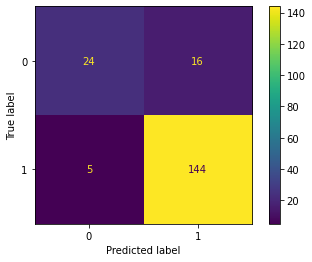

In [113]:
plot_confusion_matrix(logreg_smote, X_val_scaled, y_val)

#### Scoring

In [114]:
# fit model on training data
logreg2.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = logreg2.predict(X_train_scaled)
val_preds = logreg2.predict(X_val_scaled)
# get recall score
logreg2_recall_score_train = recall_score(y_train, train_preds)
logreg2_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
logreg2_accuracy_score_train = accuracy_score(y_train, train_preds)
logreg2_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
logreg2_precision_score_train = precision_score(y_train, train_preds)
logreg2_precision_score_val = precision_score(y_val, val_preds)

### KNN

In [115]:
#import KNN Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# Initiate model
knn = KNeighborsClassifier(3)
# Run through modeling function
knn_model = modeling_function(knn, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  0.899624765478424
Validation accuracy:  0.873015873015873


#### Scoring

In [116]:
# fit model on training data
knn.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = knn.predict(X_train_scaled)
val_preds = knn.predict(X_val_scaled)
# get recall score
knn_recall_score_train = recall_score(y_train, train_preds)
knn_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
knn_accuracy_score_train = accuracy_score(y_train, train_preds)
knn_accuracy_score_val = accuracy_score(y_val, val_preds)

# get precision score
knn_precision_score_train = precision_score(y_train, train_preds)
knn_precision_score_val = precision_score(y_val, val_preds)

### Decision tree

In [117]:
# Initiate Decision Tree
dt = DecisionTreeClassifier(random_state=2021)

In [118]:
# Call modeling function and pass through training and validation data
dt = modeling_function(dt, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  1.0
Validation accuracy:  0.8359788359788359


#### Scoring

In [119]:
# fit model on training data
dt.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = dt.predict(X_train_scaled)
val_preds = dt.predict(X_val_scaled)
# get recall score
dt_recall_score_train = recall_score(y_train, train_preds)
dt_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
dt_accuracy_score_train = accuracy_score(y_train, train_preds)
dt_accuracy_score_val = accuracy_score(y_val, val_preds)

# get precision score
dt_precision_score_train = precision_score(y_train, train_preds)
dt_precision_score_val = precision_score(y_val, val_preds)

### XG Boost

In [120]:
# Import xgboost
from xgboost import XGBClassifier

In [121]:
# Initiate XGB
clf = XGBClassifier()

In [122]:
# Fit training data
clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# Run model on training and validation data
training_preds = clf.predict(X_train_scaled)
test_preds = clf.predict(X_val_scaled)

In [124]:
# Get training and testing acuracy
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_val, test_preds)

In [125]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 86.77%


#### Scoring

In [126]:
# fit model on training data
clf.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = clf.predict(X_train_scaled)
val_preds = clf.predict(X_val_scaled)
# get recall score
clf_recall_score_train = recall_score(y_train, train_preds)
clf_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
clf_accuracy_score_train = accuracy_score(y_train, train_preds)
clf_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
clf_precision_score_train = precision_score(y_train, train_preds)
clf_precision_score_val = precision_score(y_val, val_preds)

print('')
print('Training Recall: {:.4}%'.format(clf_recall_score_train * 100))
print('Validation Recall: {:.4}%'.format(clf_recall_score_val * 100))


Training Recall: 100.0%
Validation Recall: 95.3%


### XG Boost tuning

In [127]:
# Create paramiter grid to do hyperperamiter tuning
param_grid = {
    'learning_rate': [0.04, 0.05, 0.1],
    'max_depth': [7],
    'min_child_weight': [1, 2.5],
    'subsample': [0.5, 0.6, 0.7],
    'n_estimators': [225, 250, 275],
}

In [128]:
# Initiate grid search
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
# Fit to training data
grid_clf.fit(X_train_scaled, y_train)
# Get the best parameters
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))
# Run model through training and validation data
training_preds = grid_clf.predict(X_train_scaled)
test_preds = grid_clf.predict(X_val_scaled)
# Calculate training and test accuracy for model
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_val, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.05
max_depth: 7
min_child_weight: 1
n_estimators: 250
subsample: 0.7

Training Accuracy: 99.62%
Validation accuracy: 88.89%


#### Scoring

In [129]:
# fit model on training data
grid_clf.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_val_scaled)
# get recall score
grid_clf_recall_score_train = recall_score(y_train, train_preds)
grid_clf_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
grid_clf_accuracy_score_train = accuracy_score(y_train, train_preds)
grid_clf_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
grid_clf_precision_score_train = precision_score(y_train, train_preds)
grid_clf_precision_score_val = precision_score(y_val, val_preds)

print('')
print('Training Recall: {:.4}%'.format(grid_clf_recall_score_train * 100))
print('Validation Recall: {:.4}%'.format(grid_clf_recall_score_val * 100))


Training Recall: 100.0%
Validation Recall: 96.64%


### Support Vector Machine

In [130]:
from sklearn.svm import SVC

In [131]:
#poly kernel must pass in degree 
svm = SVC(kernel='poly', degree=3)
clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
y_pred = clf.predict(X_val_scaled)

In [133]:
# Call modeling function and pass through training and validation data
svm = modeling_function(clf, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  1.0
Validation accuracy:  0.8677248677248677


#### Scoring

In [134]:
# fit model on training data
svm.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = svm.predict(X_train_scaled)
val_preds = svm.predict(X_val_scaled)
# get recall score
svm_recall_score_train = recall_score(y_train, train_preds)
svm_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
svm_accuracy_score_train = accuracy_score(y_train, train_preds)
svm_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
svm_precision_score_train = precision_score(y_train, train_preds)
svm_precision_score_val = precision_score(y_val, val_preds)
print('')
print('Training Recall: {:.4}%'.format(svm_recall_score_train * 100))
print('Validation Recall: {:.4}%'.format(svm_recall_score_val * 100))


Training Recall: 100.0%
Validation Recall: 95.3%


### Best Model (KNN)

In [135]:
# Create data frame for X_test
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

In [136]:
# Scale testing data
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed))

In [137]:
# Run testing data through model
test_preds = knn.predict(X_test_scaled)

In [138]:
# Get the accuracy score
accuracy_score(y_test, test_preds)

0.8210023866348448

In [139]:
recall_score(y_test, test_preds)

0.8975155279503105

In [140]:
precision_score(y_test, test_preds)

0.8731117824773413

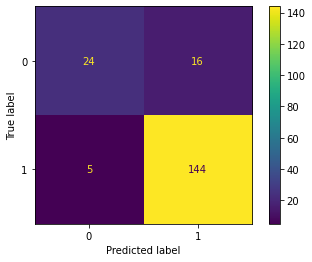

In [141]:
plot_confusion_matrix(grid_clf, X_val_scaled, y_val)